## Imports

In [1]:
import pyspark
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
from functools import reduce
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, expr
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF, Normalizer, StopWordsRemover
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import StringType, DoubleType, IntegerType
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

## Preprocessing

We first initialize the spark session and then import all the data from user reviews. Here is a link to our dataset: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews 

In [2]:
spark = SparkSession.builder.appName("balancing").getOrCreate()

In [3]:
csv_files = glob.glob('./dataset/reviews_*.csv')
dfs = []
for file in csv_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    dfs.append(df)
data = reduce(lambda df1, df2: df1.union(df2), dfs)

Now we ask: are the reviews of different products balanced? ie, do we have enough reviews of every item ? To answer this, let's take a look at the distribution of our data

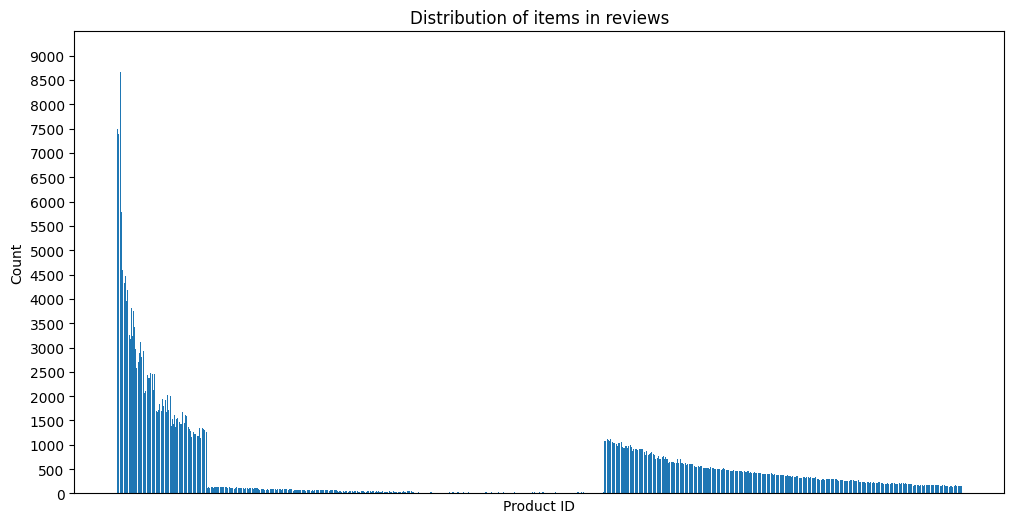

In [4]:
items = data.groupBy('product_id').count()
item_stats = items.filter(col('count').isNotNull() & col('product_id').startswith('P'))
pandas_items = item_stats.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(pandas_items['product_id'], pandas_items['count'])
plt.xticks([])
plt.ylim(0, 9500)
plt.yticks(range(0, 9500, 500))
plt.xlabel('Product ID')
plt.ylabel('Count')
plt.title('Distribution of items in reviews')
plt.show()

As we can see, the set is greatly imbalaced, the  majority of products have between 500 and a little over 1000, with a considerable number having less than 500 and a few over 2000. To account for popularity, or lack thereof, of all items, we will maintain all those datapoints in our datamodel.

Now we ask ourselves this: do we a balanced amount of reviews across users? To answer this, given we have a long-tailed data set, we will build a histogram.

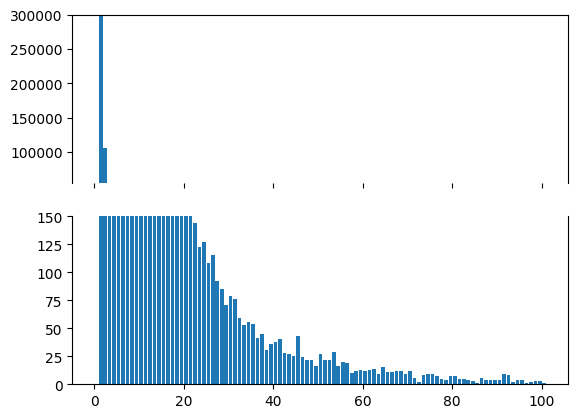

<Figure size 1200x600 with 0 Axes>

In [5]:
user_reviews = data.groupBy('author_id').count()
user_reviews =user_reviews.filter(col('author_id').isNotNull()).drop('author_id')
pandas_reviews = user_reviews.toPandas()
pandas_reviews = pandas_reviews.sort_values(by=['count'])
bin_edges = np.linspace(0, 100, 1000)
bin_centres = np.linspace(0.5, 100.5, 999)
my_hist = np.histogram(pandas_reviews['count'], bins = bin_edges)[0]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, facecolor = 'w')
ax1.bar(bin_centres, my_hist) # plot on top axes
ax2.bar(bin_centres, my_hist) # plot on bottom axes
ax1.set_ylim(55000, 300000)  # outliers only
ax2.set_ylim(0, 150)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_bottom() 
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
plt.figure(figsize=(12, 6))
plt.show()

As we can see, Many users have very few reviews while a few have many reviews

We can now start taking a look into our data itself.

We want to disregard items that aren't related to skin type, eye colour or skin tone. Let's look at the item categories we have.

In [6]:
product_data_df = spark.read.csv('dataset/product_info.csv', header=True, inferSchema=True)
product_data_df.select('primary_category').distinct().show()
product_data_df.select('secondary_category').distinct().show()

+-----------------+
| primary_category|
+-----------------+
|  Tools & Brushes|
|         Skincare|
| 'All Hair Types'|
|        Mini Size|
|              Men|
|      Bath & Body|
|        Fragrance|
|   'Long-wearing'|
|             Hair|
|           Makeup|
|            Gifts|
|             NULL|
+-----------------+

+--------------------+
|  secondary_category|
+--------------------+
|        Moisturizers|
|               Masks|
|            Wellness|
|  Beauty Accessories|
| 'Good for: Dryness'|
|  Beauty Supplements|
|Candles & Home Sc...|
|     Makeup Palettes|
|          Hair Tools|
|            Skincare|
|   Body Moisturizers|
|        'Waterproof'|
|Shampoo & Conditi...|
|               Tools|
|Brushes & Applica...|
|           Cleansers|
|        Beauty Tools|
|          Treatments|
|               Cheek|
|           Body Care|
+--------------------+
only showing top 20 rows



We can now see that we essentially want to keep skincare category products 

In [7]:
filtered_product_data_df = product_data_df.filter(
    ~col('primary_category').isin(['Fragrance', 'Hair', 'All Hair Types']) &
    ~col('secondary_category').isin(['Fragrance','Hair Tools', 'Shampoo & Conditioner']))
#filtered_product_data_df.select('product_id', 'primary_category', 'secondary_category', 'tertiary_category').show(10)
#filtering out reviews of unexisting products
valid_product_ids_df = filtered_product_data_df.select('product_id').distinct()
valid_reviews_df = data.join(valid_product_ids_df, "product_id", "inner").drop(valid_product_ids_df.product_id)

Now that we have the relevant review, we want to ensure that every review of a skincare product, has the relevant user info i.e `skin_type`.

In [8]:
skin_type_reviews_df = valid_reviews_df.filter(
        col('skin_type').isin(['dry','combination','oily','normal'])
        )
valid_reviews_df = skin_type_reviews_df.select(
        col('product_id'),
        col('author_id'),
        col('is_recommended'),
        col('review_text'),
        col('review_title'),
        col('product_name'),
        col('skin_type'),
        col('brand_name'),
        col('rating'),
        )
print(valid_reviews_df.count())
valid_reviews_df.show()

980566
+----------+-----------+--------------+--------------------+--------------------+--------------------+-----------+----------+------+
|product_id|  author_id|is_recommended|         review_text|        review_title|        product_name|  skin_type|brand_name|rating|
+----------+-----------+--------------+--------------------+--------------------+--------------------+-----------+----------+------+
|   P504322| 1741593524|           1.0|I use this with t...|Taught me how to ...|Gentle Hydra-Gel ...|        dry|  NUDESTIX|     5|
|   P420652| 5061282401|           1.0|My review title s...|New Favorite Routine|Lip Sleeping Mask...|        dry|   LANEIGE|     5|
|   P420652| 6083038851|           1.0|I’ve always loved...|Can't go wrong wi...|Lip Sleeping Mask...|combination|   LANEIGE|     5|
|   P420652|47056667835|           1.0|If you have dry c...|     A must have !!!|Lip Sleeping Mask...|combination|   LANEIGE|     5|
|   P420652|42802569154|           1.0|The scent isn’t m...|  

Now that we have only the valid reviews and products, let's take a look at our distributions again.

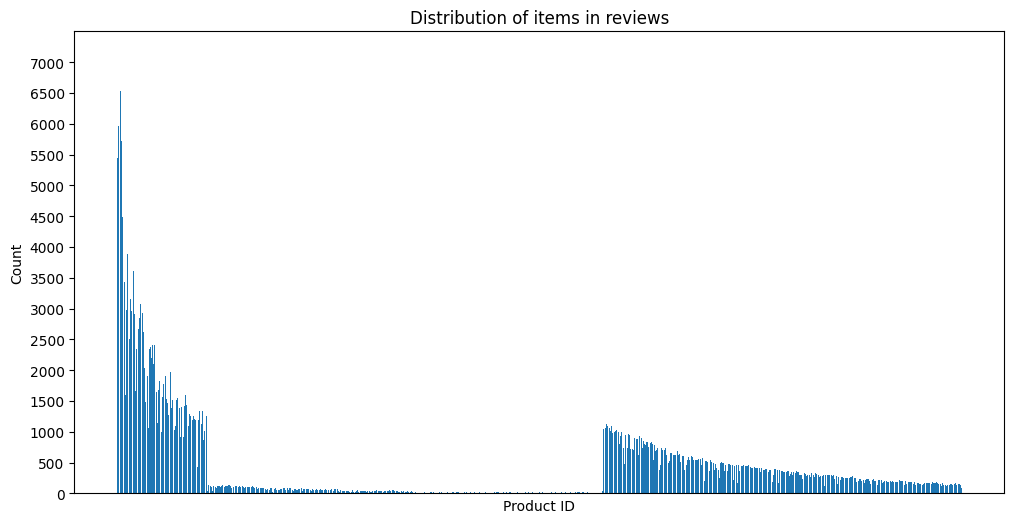

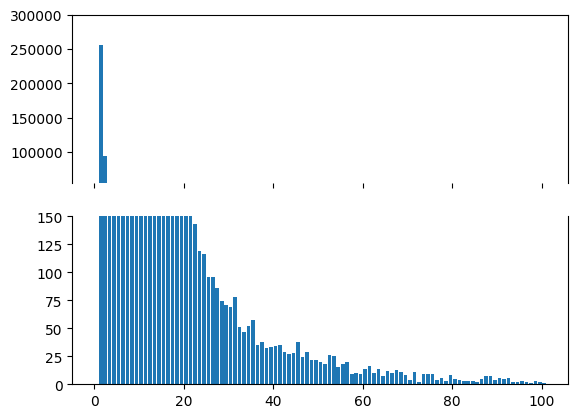

<Figure size 1200x600 with 0 Axes>

In [9]:
valid_items = valid_reviews_df.groupBy('product_id').count()
pandas_valid_items = valid_items.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(pandas_valid_items['product_id'], pandas_valid_items['count'])
plt.xticks([])
plt.ylim(0, 7500)
plt.yticks(range(0, 7500, 500))
plt.xlabel('Product ID')
plt.ylabel('Count')
plt.title('Distribution of items in reviews')
plt.show()
valid_user_reviews = valid_reviews_df.groupBy('author_id').count()
valid_user_reviews = valid_user_reviews.filter(col('author_id').isNotNull()).drop('author_id')
pandas_reviews = valid_user_reviews.toPandas()
pandas_reviews = pandas_reviews.sort_values(by=['count'])
bin_edges = np.linspace(0, 100, 1000)
bin_centres = np.linspace(0.5, 100.5, 999)
my_hist = np.histogram(pandas_reviews['count'], bins = bin_edges)[0]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, facecolor = 'w')
ax1.bar(bin_centres, my_hist) # plot on top axes
ax2.bar(bin_centres, my_hist) # plot on bottom axes
ax1.set_ylim(55000, 300000)  # outliers only
ax2.set_ylim(0, 150)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_bottom() 
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
plt.figure(figsize=(12, 6))
plt.show()

As we see, even after data preprocessing, our distribution doesn't change much and is still very imbalanced.

## Content Based Filtering using TF-IDF

In this section, we will compute the similarity score between different products based on their text features which will be derivied from the `review_text` column. This will allow us to recommend products that are similar to a selected product.

We will first ensure that the `review_text` field is a string and remove any missing records

In [10]:
valid_reviews_df = valid_reviews_df.withColumn("review_text", col("review_text").cast(StringType()))
filtered_data = valid_reviews_df.filter(col("review_text").isNotNull())

Next, we will tokenize the `review_text` of each product to create a list of words. We will also remove any stop words to ensure accuracy and to recude noice in data

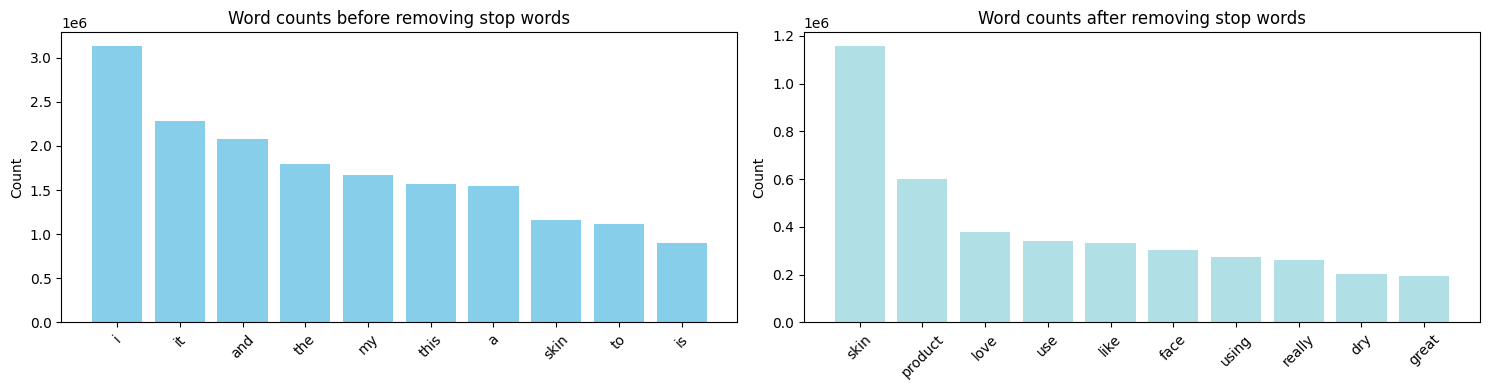

In [16]:
# Tokenize
tokenizer = RegexTokenizer(inputCol="review_text", outputCol="words", pattern="\\W")
tokenized_df = tokenizer.transform(filtered_data)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(tokenized_df)

# Convert lists of words to rdd
rdd_before = tokenized_df.select('words').rdd.flatMap(lambda x: x[0]).map(lambda x: (x, 1))
rdd_after = filtered_df.select('filtered_words').rdd.flatMap(lambda x: x[0]).map(lambda x: (x, 1))

# Count
count_before = rdd_before.reduceByKey(lambda a, b: a + b)
count_after = rdd_after.reduceByKey(lambda a, b: a + b)

# Convert back to df
df_count_before = count_before.toDF(["word", "count"])
df_count_after = count_after.toDF(["word", "count"])

# Convert spark df to pandas df
pd_count_before = df_count_before.toPandas()
pd_count_after = df_count_after.toPandas()

# Sort and take the top 10 words
words_before = pd_count_before.sort_values(by='count', ascending=False).head(10)
words_after = pd_count_after.sort_values(by='count', ascending=False).head(10)

# Plot barchart
plt.figure(figsize=[15, 4])
plt.subplot(1, 2, 1)
plt.bar(words_before['word'], words_before['count'], color='skyblue')
plt.title('Word counts before removing stop words')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.bar(words_after['word'], words_after['count'], color='powderblue')
plt.title('Word counts after removing stop words')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Calculate the Term Frequency-Inverse Document Frequency**

We will now compute the Term Frequency-Inverse Document Frequency which will help deteremine the significance of words in the `review_text` compared to all other reviews. This method involves two steps:
1. **Term Frequency (TF):** This mesaures how often a word occurs within a single review.

2. **Inverse Document Frequency (IDF):** This measures how common is a word across all reviews.

By multiplying TF by IDF, we can compute a score for each word in a review that reflects its importance in that specific review and across all other reviews.
This will give us a matrix where each row represents a different product and each column represents a unique word from the `review_text` vocabulary.

In [17]:
# Calculate term frequency
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
featurized_df = hashingTF.transform(filtered_df)

# Calculate inverse document frequency
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurized_df)
rescaledData = idfModel.transform(featurized_df)

Then we will normalize the TF-IDF vectors and convert them into normalized feature vectors. This will adjust the vectors to have a unit length which will later ensure accurate similarity comparisons.

In [18]:
normalizer = Normalizer(inputCol="features", outputCol="normFeatures")
normalizedData = normalizer.transform(rescaledData)

# Index product_id to align with ALS model
indexer = StringIndexer(inputCol="product_id", outputCol="product_id_index").setHandleInvalid("keep")
indexedData = indexer.fit(normalizedData).transform(normalizedData)

We will choose a specific `product_name` and retrieve its feature vector from the dataset.

In [19]:
# Choose a product name
selected_product_name = 'Gentle Hydra-Gel Face Cleanser' 

# Get the TF-IDF vector for the choosen product
selected_product_vector = normalizedData.filter(col('product_name') == selected_product_name).select('normFeatures').first()
selected_product_row = indexedData.filter(col('product_name') == selected_product_name).select('product_id_index', 'normFeatures').first()

if selected_product_row:
    selected_product_vector = selected_product_row['normFeatures']
    selected_product_index = selected_product_row['product_id_index']
else:
    raise ValueError(f"The product name was not found in the dataset")

**Calculate Cosine Similarity and Generate Recommendations**

In this last step, we will define a user-defined function (UDF) for cosine similarity and apply it to our dataset to find similar products. We will then sort the products based on their similarity scores to recommend the top 10 similar products.
Finally, we will generate recommendations by passing `product_name` as the first argument and the `cosine_similarity` as the second argument.

In [21]:
# Define cosine similarity UDF
@udf(DoubleType())
def cosine_sim(vector):
    if vector is not None:
        vec1 = np.array(vector.toArray())
        vec2 = np.array(selected_product_vector.toArray())
        # Prevent division by zero
        if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
            return 0.0
        return float(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
    else:
        return None

# Add a new column with cosine similarity scores
similar_products = indexedData.withColumn("cosine_similarity", cosine_sim(col("normFeatures")))

# Exclude the selected product name and sort df based on similarity scores
get_recommendations = similar_products.filter(col('product_name') != selected_product_name).orderBy(col("cosine_similarity").desc())

get_recommendations = get_recommendations.withColumn("author_id", col("author_id").cast(IntegerType())).filter(col("author_id").isNotNull())

# Show top 10 most similar products
get_recommendations.select('product_name', 'product_id', 'product_id_index', 'author_id', 'cosine_similarity').show(10, truncate=False)

+----------------------------------------------------------------+-------------------+
|product_name                                                    |cosine_similarity  |
+----------------------------------------------------------------+-------------------+
|Vinosource-Hydra Moisturizing Sorbet                            |0.5347435333611855 |
|Rosebud Salve in a Tube                                         |0.49848899517295814|
|Green Clean Makeup Removing Cleansing Balm                      |0.49547433217639736|
|Green Clean Makeup Meltaway Cleansing Balm Limited Edition Jumbo|0.49547433217639736|
|The Camellia Oil 2-in-1 Makeup Remover & Cleanser               |0.4840096736678198 |
|Watermelon Glow Ultra-Fine Mist                                 |0.4649158307302416 |
|Take The Day Off Cleansing Balm Makeup Remover                  |0.4598788414379218 |
|Mini Take The Day Off Cleansing Balm Makeup Remover             |0.4598788414379218 |
|Clean Bee Ultra Gentle Facial Cleanser    

## Collaborative Based Filtering

First, we need to convert all of the columns that will be used in the model to numeric before we can begin the modeling process.For the PySpark's ALS model, this is required. The column that is going to be converted is `product_id` using StringIndexer. For converting column `rating` and `author_id` to numeric, `cast()` fucntion will be used .

In [10]:
indexer_string = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['product_id']]
indexer = [current_indexer.setHandleInvalid("keep") for current_indexer in indexer_string]
pipeline = Pipeline(stages=indexer)
valid_collaborative_df =valid_reviews_df.drop(
        col('review_text'),
        col('review_title')
        )
valid_reviews_df.show()
transformed = pipeline.fit(valid_reviews_df).transform(valid_reviews_df)
collaborative_data = transformed.select(['product_id','product_id_index',"rating","author_id"])
collaborative_data_1 = collaborative_data.withColumn("rating", col("rating").cast("double")).filter(col("rating").isNotNull())
collaborative_data_final = collaborative_data_1.withColumn("author_id", col("author_id").cast("integer")).filter(col("author_id").isNotNull())
collaborative_data_final.dtypes

+----------+-----------+--------------+--------------------+--------------------+--------------------+-----------+----------+------+
|product_id|  author_id|is_recommended|         review_text|        review_title|        product_name|  skin_type|brand_name|rating|
+----------+-----------+--------------+--------------------+--------------------+--------------------+-----------+----------+------+
|   P504322| 1741593524|           1.0|I use this with t...|Taught me how to ...|Gentle Hydra-Gel ...|        dry|  NUDESTIX|     5|
|   P420652| 5061282401|           1.0|My review title s...|New Favorite Routine|Lip Sleeping Mask...|        dry|   LANEIGE|     5|
|   P420652| 6083038851|           1.0|I’ve always loved...|Can't go wrong wi...|Lip Sleeping Mask...|combination|   LANEIGE|     5|
|   P420652|47056667835|           1.0|If you have dry c...|     A must have !!!|Lip Sleeping Mask...|combination|   LANEIGE|     5|
|   P420652|42802569154|           1.0|The scent isn’t m...|         

[('product_id', 'string'),
 ('product_id_index', 'double'),
 ('rating', 'double'),
 ('author_id', 'int')]

We will now split the dataset into training and test set by 80% and 20% and also set seed 45

In [11]:
(training, test) = collaborative_data_final.randomSplit([0.8, 0.2],  seed=50)

Build the recommendation model using ALS on the training data. We have our cold start strategy set to `drop` in order to prevent receiving NaN evaluation metrics.

In [12]:
# initialize als optimizer
als = ALS(maxIter=15,rank=70, regParam=0.01, coldStartStrategy="drop" ,userCol="author_id", itemCol="product_id_index", ratingCol="rating").setSeed(50)
model = als.fit(training)

We will generate Top 5 product recommendations for each user

In [17]:
recs = model.recommendForAllUsers(5).show(5,truncate=False)

+---------+---------------------------------------------------------------------------------------------+
|author_id|recommendations                                                                              |
+---------+---------------------------------------------------------------------------------------------+
|632059   |[{31, 4.99762}, {30, 4.997618}, {1029, 4.352835}, {1255, 4.126942}, {1681, 4.0807743}]       |
|763948   |[{46, 4.998234}, {792, 4.2291193}, {698, 4.1904726}, {194, 4.1899853}, {601, 4.134511}]      |
|840147   |[{441, 4.99865}, {1263, 4.7081027}, {795, 4.697503}, {839, 4.662235}, {1121, 4.641612}]      |
|917434   |[{1822, 6.717032}, {682, 6.5778036}, {1342, 6.4324346}, {691, 6.283565}, {1540, 6.2290263}]  |
|1115427  |[{82, 3.9981055}, {1560, 3.4457946}, {1029, 3.1715248}, {1423, 2.7986896}, {1098, 2.7428331}]|
+---------+---------------------------------------------------------------------------------------------+
only showing top 5 rows



## Model Evaluation

### Root Mean Squared Error (RMSE)
Let us now evaluate our ALS model with the given parameters

In [14]:
predictions = model.transform(test)
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating",
                                    predictionCol="prediction")
print(rmse_evaluator.evaluate(predictions))
print(mae_evaluator.evaluate(predictions))

1.8095629279828198
1.243850952551997


As we can see, our RMSE is of ~1.809 and the MAE is ~1.24

In [15]:
# initialize als optimizer
als2 = ALS(maxIter=15,rank=70, regParam=0.01, coldStartStrategy="drop" ,userCol="author_id", itemCol="product_id_index", ratingCol="rating", implicitPrefs=True).setSeed(50)
model2 = als2.fit(training)

In [16]:
predictions2 = model2.transform(test)
print(rmse_evaluator.evaluate(predictions2))
print(mae_evaluator.evaluate(predictions2))

4.185090146650962
4.02384128263834


### Mean Reciprocal Rank (MRR)
Next, we are going to evaluate the performance of the TF-IDF model using the Mean Reciprocal Rank (MRR) metric with the ALS model's recommendations as the ground truth

In [ ]:
# Flatten the ALS recommendations for easier comparison with the TF-IDF recommendations
als_recs = recs.selectExpr("author_id", "explode(recommendations) as recs").select("author_id", "recs.product_id_index")

# Join TF-IDF recommendations with ALS recommendations to find the position
ranked_recs = (
    get_recommendations
    .join(als_recs, on=["author_id", "product_id_index"])
    .withColumn("rank", expr("row_number() over (partition by author_id order by cosine_similarity desc)"))
)

# Compute the reciprocal rank for each user's recommendation
reciprocal_ranks = ranked_recs.selectExpr("author_id", "1/rank as reciprocal_rank")

# Compute MRR
mrr = reciprocal_ranks.groupBy().avg("reciprocal_rank").first()[0]

print(f"Mean Reciprocal Rank: {mrr}")